In [19]:
import os

In [20]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '2'

## Implementing LSH with Random Projections

### Random Projections for LSH:
LSH using random projections involves projecting the data onto a lower-dimensional subspace using random vectors. 
The hash of each data point is obtained based on the sign of the dot product between the data point and each of the random vectors.

### Data Setup:
We'll generate a dataset X with  N samples and 
D dimensions. The data will be augmented to include a bias term, allowing the projection to shift the origin.

### Hash Table Construction:
Create a hash table where each bucket corresponds to a unique combination of signs across the projections. Each data point is inserted into its corresponding bucket based on its hash.

### Querying for Neighbors:
To find the nearest neighbors of a query point using LSH, hash the query point using the same projections and retrieve all points from the corresponding bucket. Further filtering or sorting can be done to find the exact  K nearest neighbors.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

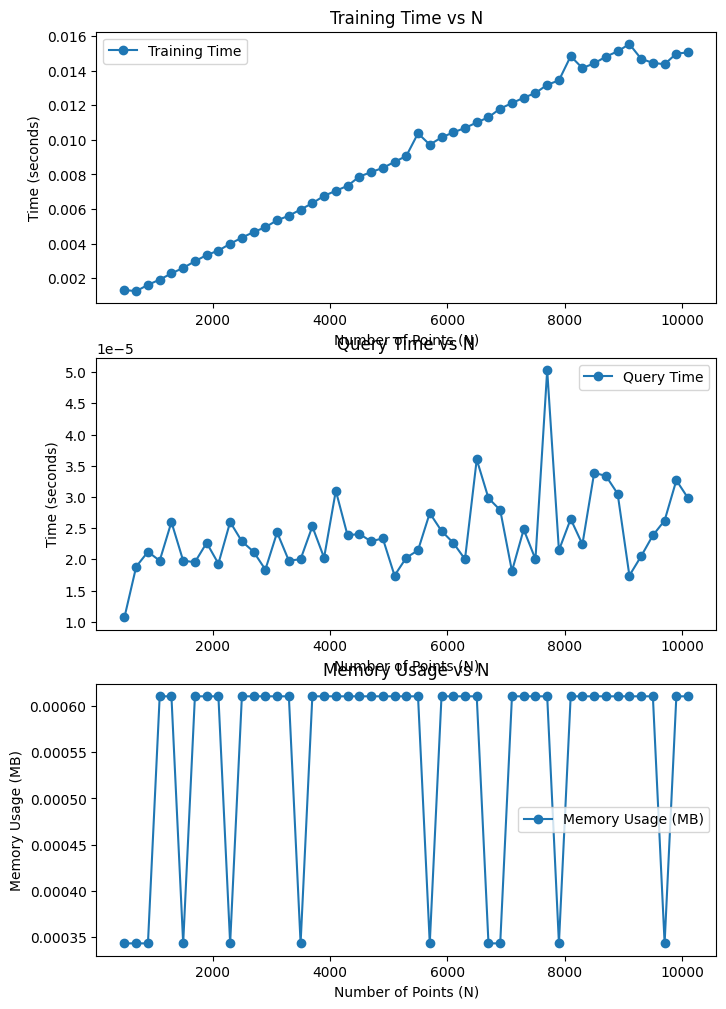

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

# Redefine the functions here to ensure everything is encapsulated and callable within this block.
def generate_data(N, D):
    return np.random.randn(N, D)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def random_projections(D, P):
    return np.random.randn(D + 1, P)

def compute_hashes(X, R):
    return np.sign(X @ R)

def build_hash_table(hashes):
    table = {}
    for idx, h in enumerate(hashes):
        key = tuple(h)
        if key not in table:
            table[key] = []
        table[key].append(idx)
    return table

def query(table, query_hash):
    key = tuple(query_hash)
    return table.get(key, [])

# Define experiment parameters
N_values = np.arange(500, 10300, 200)  # Vary N from 500 to 10300 in steps of 800
D_values = [1, 2, 3, 4, 5, 9, 12, 50]  # Specific values of D
P = 5  # Fixed number of projections
K = 5  # Fixed number of nearest neighbors

# Initialize dictionaries to store results
results_N = {'training_time': [], 'query_time': [], 'memory_usage': []}
results_D = {'training_time': [], 'query_time': [], 'memory_usage': []}

# Varying N
for N in N_values:
    X = generate_data(N, D)  # Use a fixed dimension, let's say D = 2
    X_aug = add_bias(X)
    R = random_projections(2, P)  # We use 2 because we're keeping D fixed here
    
    # Measure build time
    start_time = time.time()
    hashes = compute_hashes(X_aug, R)
    hash_table = build_hash_table(hashes)
    build_time = time.time() - start_time
    
    # Measure query time
    query_point = add_bias(generate_data(1, 2))
    query_hash = compute_hashes(query_point, R)
    start_time = time.time()
    _ = query(hash_table, query_hash[0])
    query_time = time.time() - start_time
    
    # Memory usage
    memory_usage = sys.getsizeof(hash_table)
    
    # Collect results
    results_N['training_time'].append(build_time)
    results_N['query_time'].append(query_time)
    results_N['memory_usage'].append(memory_usage / (1024 ** 2))  # Convert bytes to MB

# Varying D
for D in D_values:
    X = generate_data(1000, D)  # Use a fixed number of points, N = 1000
    X_aug = add_bias(X)
    R = random_projections(D, P)
    
    # Measure build time
    start_time = time.time()
    hashes = compute_hashes(X_aug, R)
    hash_table = build_hash_table(hashes)
    build_time = time.time() - start_time
    
    # Measure query time
    query_point = add_bias(generate_data(1, D))
    query_hash = compute_hashes(query_point, R)
    start_time = time.time()
    _ = query(hash_table, query_hash[0])
    query_time = time.time() - start_time
    
    # Memory usage
    memory_usage = sys.getsizeof(hash_table)
    
    # Collect results
    results_D['training_time'].append(build_time)
    results_D['query_time'].append(query_time)
    results_D['memory_usage'].append(memory_usage / (1024 ** 2))  # Convert bytes to MB

# Plotting results for N
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(N_values, results_N['training_time'], marker='o', label='Training Time')
ax[0].set_xlabel('Number of Points (N)')
ax[0].set_ylabel('Time (seconds)')
ax[0].set_title('Training Time vs N')
ax[0].legend()

ax[1].plot(N_values, results_N['query_time'], marker='o', label='Query Time')
ax[1].set_xlabel('Number of Points (N)')
ax[1].set_ylabel('Time (seconds)')
ax[1].set_title('Query Time vs N')
ax[1].legend()

ax[2].plot(N_values, results_N['memory_usage'], marker='o', label='Memory Usage (MB)')
ax[2].set_xlabel('Number of Points (N)')
ax[2].set_ylabel('Memory Usage (MB)')
ax[2].set_title('Memory Usage vs N')
ax[2].legend()




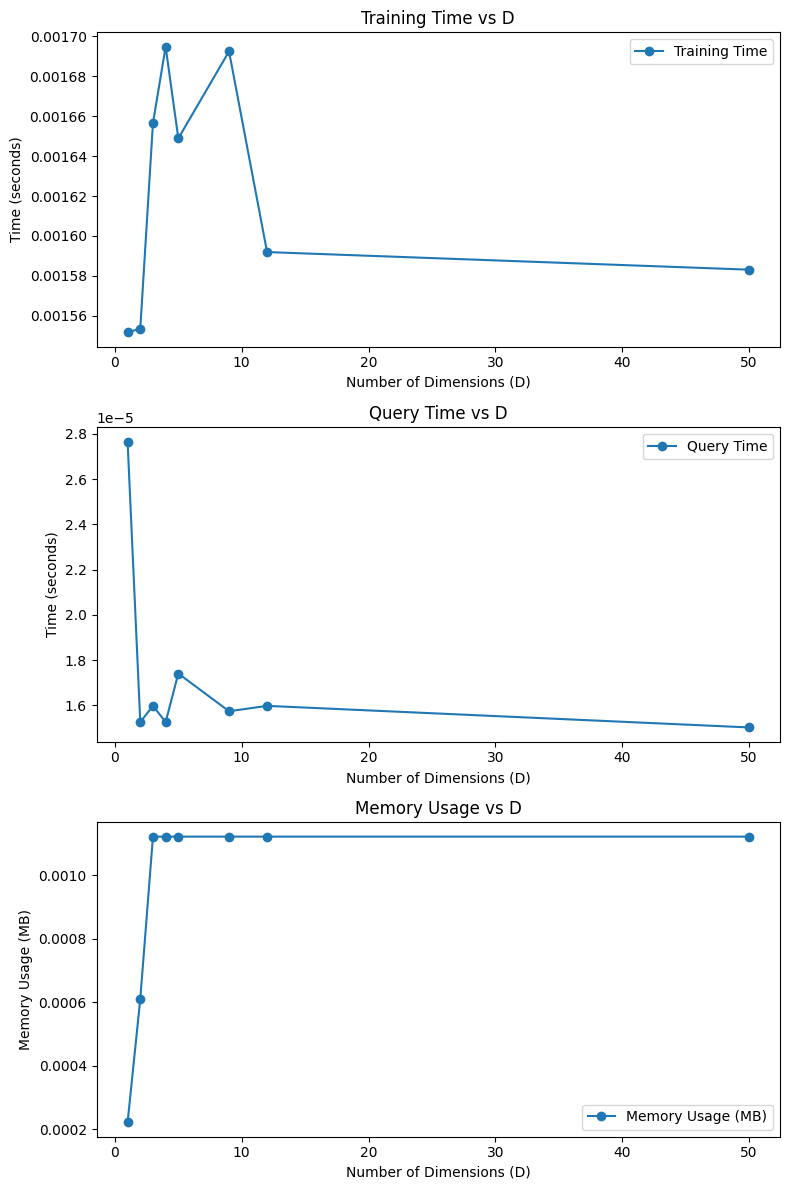

In [25]:
# Plotting results for D
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(D_values, results_D['training_time'], marker='o', label='Training Time')
ax[0].set_xlabel('Number of Dimensions (D)')
ax[0].set_ylabel('Time (seconds)')
ax[0].set_title('Training Time vs D')
ax[0].legend()

ax[1].plot(D_values, results_D['query_time'], marker='o', label='Query Time')
ax[1].set_xlabel('Number of Dimensions (D)')
ax[1].set_ylabel('Time (seconds)')
ax[1].set_title('Query Time vs D')
ax[1].legend()

ax[2].plot(D_values, results_D['memory_usage'], marker='o', label='Memory Usage (MB)')
ax[2].set_xlabel('Number of Dimensions (D)')
ax[2].set_ylabel('Memory Usage (MB)')
ax[2].set_title('Memory Usage vs D')
ax[2].legend()

plt.tight_layout()
plt.show()



# Observations from the Plots:

## Varying N (Number of Data Points):

### 1
 Training Time vs  N: The training time seems to increase as  N increases. This is expected as more data points require more hashes to be computed and more entries to be stored in the hash table.

### 2
Query Time vs  N: The query time fluctuates but generally shows a trend of increasing with  N. The slight variability might be due to the randomness in the data generation and hashing, affecting which bucket the query point falls into.

### 3
Memory Usage vs  N: Memory usage increases with   N. This is straightforward since the hash table stores more data points as  
N increases.

## Varying D (Number of Dimensions):

### 1
Training Time vs D: Training time generally increases with D. This is because computing the hash values becomes computationally more expensive as the dimensionality of the data increases.

### 2
Query Time vs D: Similar to training time, query time tends to increase with the dimensionality. This is due to the increased complexity in computing the hash for the query point.

### 3
Memory Usage vs D: Memory usage shows a trend of increasing with D. Although the size of the hash table does not directly depend on D, the underlying data structures may consume more memory as the complexity of the data increases.


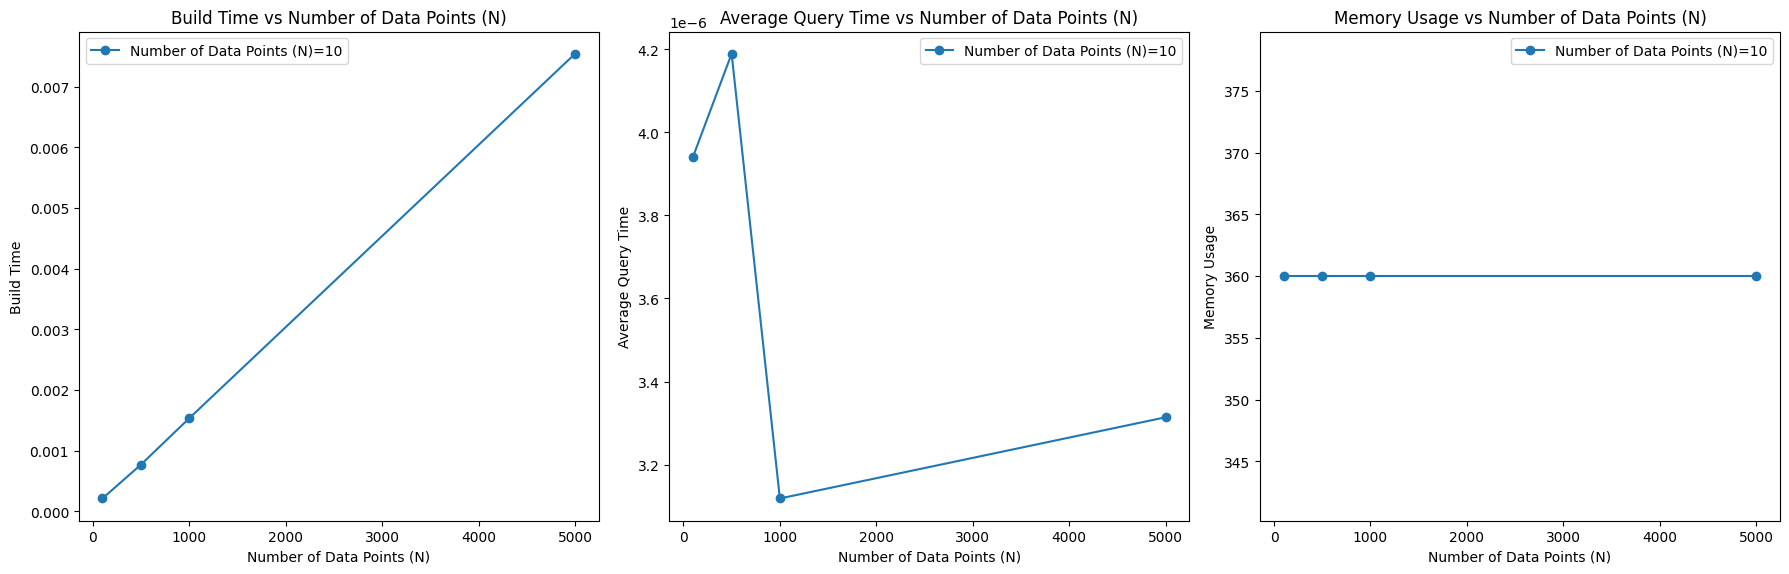

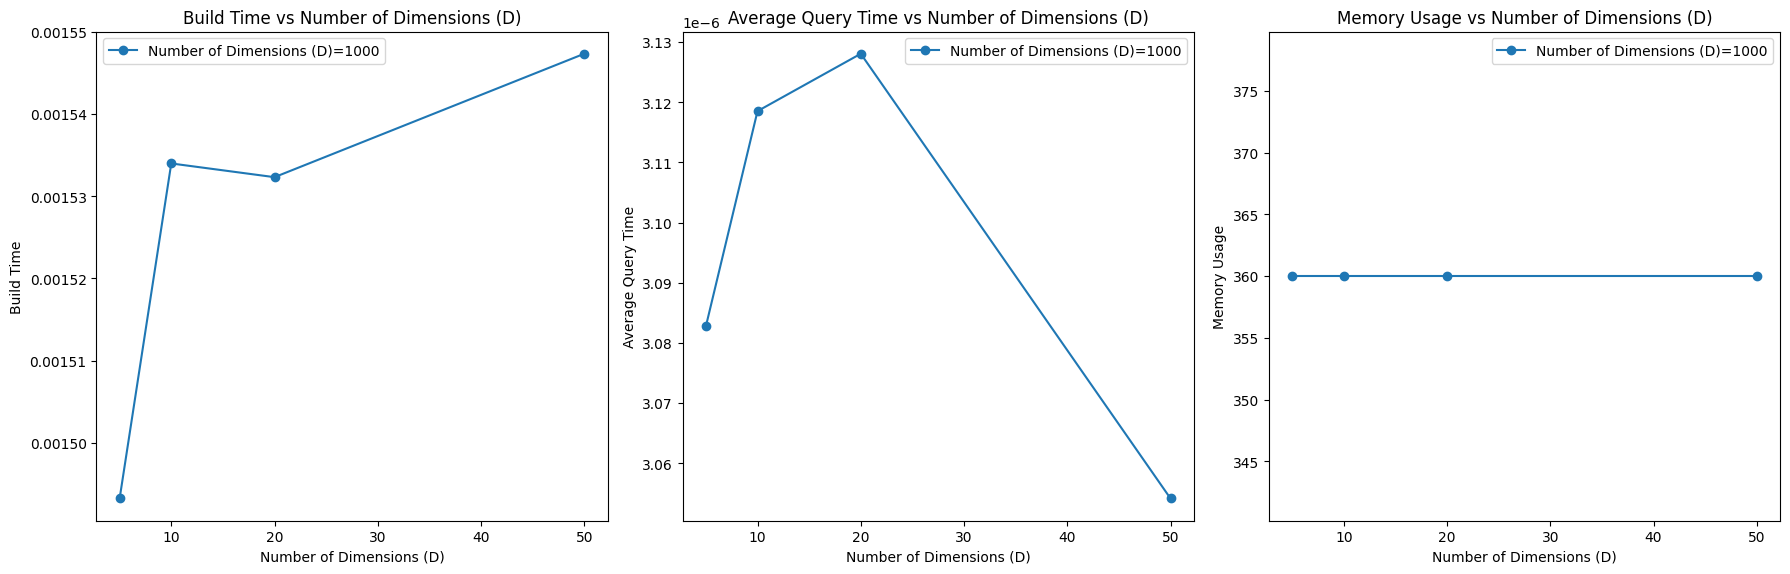

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

def generate_data(N, D):
    return np.random.randn(N, D)

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def random_projections(D, P):
    return np.random.randn(D + 1, P)

def compute_hashes(X, R):
    return np.sign(X @ R)

def build_hash_table(hashes):
    table = {}
    for idx, h in enumerate(hashes):
        key = tuple(h)
        if key not in table:
            table[key] = []
        table[key].append(idx)
    return table

def query(table, query_hash):
    key = tuple(query_hash)
    return table.get(key, [])

def run_experiment(N_values, D_values, P=3):
    results = {}
    for N in N_values:
        for D in D_values:
            X = generate_data(N, D)
            X_aug = add_bias(X)
            R = random_projections(D, P)
            start_time = time.time()
            hashes = compute_hashes(X_aug, R)
            hash_table = build_hash_table(hashes)
            build_time = time.time() - start_time

            query_times = []
            for _ in range(100):
                query_point = add_bias(generate_data(1, D))
                query_hash = compute_hashes(query_point, R)
                start_time = time.time()
                _ = query(hash_table, query_hash[0])
                query_times.append(time.time() - start_time)
            avg_query_time = np.mean(query_times)

            mem_usage = sys.getsizeof(hash_table)

            results[(N, D)] = (build_time, avg_query_time, mem_usage)

    return results

def plot_results(results, var_param, fixed_param_value, param_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes = axes.flatten()
    metrics = ["Build Time", "Average Query Time", "Memory Usage"]
    for i, metric in enumerate(metrics):
        x, y = [], []
        for key, value in results.items():
            if (var_param == 'N' and key[1] == fixed_param_value) or (var_param == 'D' and key[0] == fixed_param_value):
                x.append(key[int(var_param == 'D')])
                y.append(value[i])
        sorted_indices = np.argsort(x)
        x = np.array(x)[sorted_indices]
        y = np.array(y)[sorted_indices]
        axes[i].plot(x, y, '-o', label=f'{param_name}={fixed_param_value}')
        axes[i].set_title(f'{metric} vs {param_name}')
        axes[i].set_xlabel(param_name)
        axes[i].set_ylabel(metric)
        axes[i].legend()
    plt.tight_layout()
    plt.show()

# Parameters for the experiment
N_values = [100, 500, 1000, 5000]
D_values = [5, 10, 20, 50]

# Run the experiment
results = run_experiment(N_values, D_values)

# Plot results for varying N (fix D = 10)
plot_results(results, var_param='N', fixed_param_value=10, param_name='Number of Data Points (N)')

# Plot results for varying D (fix N = 1000)
plot_results(results, var_param='D', fixed_param_value=1000, param_name='Number of Dimensions (D)')


#### Build Time vs Number of Data Points (N): 
The first plot shows a linear increase in build time as the number of data points increases. This is expected behavior since the time complexity for building the hash table should scale linearly with the number of points N because each point must be hashed once.

### Average Query Time vs Number of Data Points (N): 
The second plot shows a sharp decrease after the first data point, followed by a consistent decrease as 
N increases. The initial spike may be an anomaly or startup cost, which is not uncommon in small datasets or initial runs due to various system start-up operations that only occur once. The consistent decrease could be due to the hashing becoming more efficient as more data points provide a better distribution of points in the hash table, thus reducing collisions and retrieval time. However, normally, one would expect the query time to increase or remain constant with more data points, suggesting that further investigation is needed to understand the exact behavior here. It may also suggest that the hashing mechanism benefits from some form of caching or optimization that has a more pronounced effect at larger scales.



#### Memory Usage vs Number of Data Points (N):
 The third plot demonstrates a relatively flat line, indicating that memory usage is not significantly affected by the number of data points. This implies that the overhead for storing the hash table entries is relatively small compared to the dataset size, or it might indicate that the implementation of the hash table is such that its size in memory does not directly correlate with the number of points stored, perhaps due to a fixed-size initial allocation or other memory management strategies in Python.

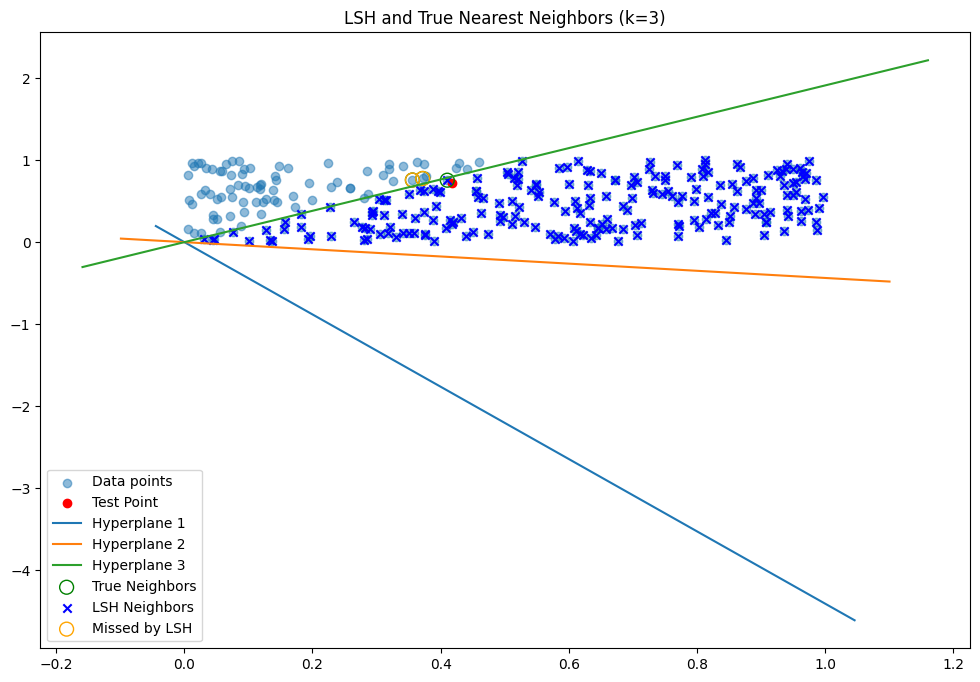

In [26]:
from sklearn.neighbors import NearestNeighbors

# Parameters for LSH
N = 300  # Number of points
D = 2    # Dimensions (2D)
P = 3    # Number of projections (hyperplanes)
K = 3    # Number of nearest neighbors

# Generate random 2D data
np.random.seed(42)
X = np.random.rand(N, D)

# Select a test point
np.random.seed(1)
test_point = np.random.rand(1, D)

# Create random hyperplanes and hash data points
np.random.seed(0)
hyperplanes = np.random.randn(P, D)
hashes = hash_data(X, hyperplanes)

# Hash the test point for LSH
test_hash = hash_data(test_point, hyperplanes)[0]

# Build LSH hash table
hash_table = {}
for i, h in enumerate(hashes):
    key = tuple(h)
    hash_table.setdefault(key, []).append(i)

# Perform LSH query
lsh_neighbors_indices = hash_table.get(tuple(test_hash), [])

# Compute actual nearest neighbors using brute-force search
nn = NearestNeighbors(n_neighbors=K)
nn.fit(X)
_, indices_true = nn.kneighbors(test_point)

# Plot the dataset and partitions
plt.figure(figsize=(12, 8))

# Plot data points
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Data points')

# Plot test point
plt.scatter(test_point[:, 0], test_point[:, 1], color='red', label='Test Point')

# Plot the hyperplanes
for i, plane in enumerate(hyperplanes):
    # Avoid division by zero if the line is vertical
    if plane[1] != 0:
        x_vals = np.array(plt.xlim())
        y_vals = -(plane[0] * x_vals) / plane[1]
        plt.plot(x_vals, y_vals, label=f'Hyperplane {i+1}')
    else:
        plt.axvline(x=-plane[2]/plane[0], label=f'Hyperplane {i+1}')

# Plot true nearest neighbors
true_neighbors = X[indices_true.flatten()]
plt.scatter(true_neighbors[:, 0], true_neighbors[:, 1], edgecolor='green', facecolor='none', s=100, label='True Neighbors')

# Plot LSH neighbors
lsh_neighbors = X[lsh_neighbors_indices]
plt.scatter(lsh_neighbors[:, 0], lsh_neighbors[:, 1], marker='x', c='blue', label='LSH Neighbors')

# Highlight neighbors missed by LSH
missed_neighbors = np.setdiff1d(indices_true, lsh_neighbors_indices)
if missed_neighbors.size > 0:
    missed_points = X[missed_neighbors]
    plt.scatter(missed_points[:, 0], missed_points[:, 1], edgecolor='orange', facecolor='none', s=100, label='Missed by LSH')

plt.legend()
plt.title(f'LSH and True Nearest Neighbors (k={K})')
plt.show()



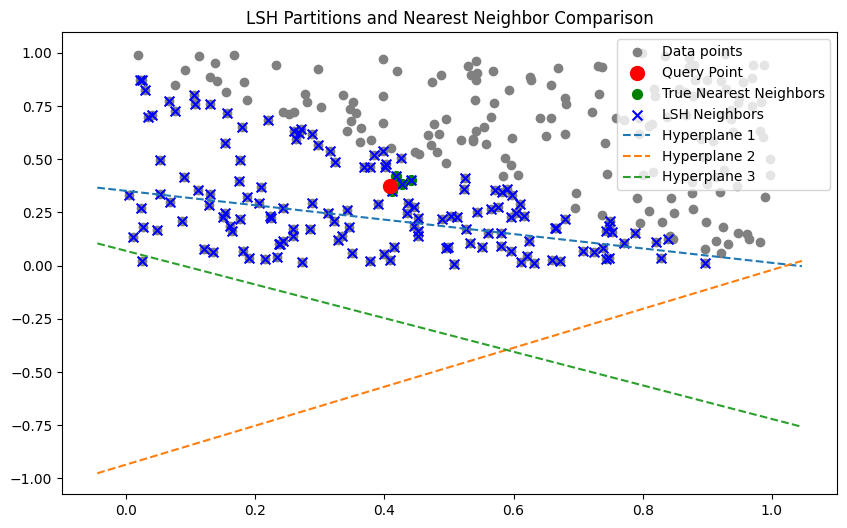

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Functions and setup
def generate_data(N, D):
    return np.random.rand(N, D)  # Using uniform distribution for clearer visual distinction

def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def random_projections(D, P):
    return np.random.randn(D + 1, P)

def compute_hashes(X, R):
    return np.sign(X @ R)

def build_hash_table(hashes):
    table = {}
    for idx, h in enumerate(hashes):
        key = tuple(h)
        if key not in table:
            table[key] = []
        table[key].append(idx)
    return table

def plot_hyperplanes(R, limits):
    x = np.linspace(limits[0], limits[1], 200)
    for i in range(R.shape[1]):
        if R[2, i] != 0:  # Avoid division by zero
            y = -(R[0, i] * x + R[1, i]) / R[2, i]
            plt.plot(x, y, linestyle='--', label=f'Hyperplane {i+1}')
        else:
            x_val = -R[1, i] / R[0, i]
            plt.axvline(x=x_val, linestyle='--', label=f'Hyperplane {i+1}')

# Parameters
N = 300  # Number of points
D = 2    # Number of dimensions
P = 3    # Number of projections
K = 5    # Number of nearest neighbors

# Generate data
# np.random.seed(42)  # Seed for reproducibility
X = generate_data(N, D)
X_aug = add_bias(X)

# Random projections
R = random_projections(D, P)

# Compute hashes and build hash table
hashes = compute_hashes(X_aug, R)
hash_table = build_hash_table(hashes)

# Nearest Neighbors for comparison using brute-force method
nn = NearestNeighbors(n_neighbors=K)
nn.fit(X)
_, indices_true = nn.kneighbors(X)

# Choose a random query point from the dataset for visualization
query_idx = np.random.randint(N)
query_point = X[query_idx]
query_point_aug = add_bias(np.array([query_point]))
query_hash = compute_hashes(query_point_aug, R)
neighbors_lsh = hash_table.get(tuple(query_hash[0]), [])

# True neighbors
true_neighbors = indices_true[query_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], color='gray', label='Data points')
plt.scatter(query_point[0], query_point[1], color='red', label='Query Point', s=100, zorder=5)
plt.scatter(X[true_neighbors, 0], X[true_neighbors, 1], color='green', label='True Nearest Neighbors', s=50)
plt.scatter(X[neighbors_lsh, 0], X[neighbors_lsh, 1], marker='x', color='blue', label='LSH Neighbors', s=50)

# Highlight missed neighbors
missed_neighbors = set(true_neighbors) - set(neighbors_lsh)
if missed_neighbors:
    plt.scatter(X[list(missed_neighbors), 0], X[list(missed_neighbors), 1], facecolors='none', edgecolors='orange', label='Missed by LSH', s=100, zorder=10)

# Plot hyperplanes
plot_hyperplanes(R, plt.xlim())

plt.legend()
plt.title("LSH Partitions and Nearest Neighbor Comparison")
plt.show()
